# BERT BASE MODEL DEVELOPMENT
Base model for binary and multiclassification against the NLTK corpus

### SETUP & LOAD DATA

In [2]:
!pip install tensorflow-datasets --quiet
# !pip install -U tensorflow-text --quiet
!pip install tensorflow-datasets
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet

Defaulting to user installation because normal site-packages is not writeable

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

2023-11-30 05:10:31.301114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 05:10:31.302595: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 05:10:31.327641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 05:10:31.327665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 05:10:31.328350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

In [4]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [5]:
MAX_SEQUENCE_LENGTH = 256

In [6]:
def create_bert_multiclass_model( model,
                                  train_layers=0,
                                  hidden_size=100,
                                  dropout=0.2,
                                  learning_rate=0.001):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        model.trainable = False

    else:
        model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    out = model(inputs)

    pooler_token = out[1]
    #cls_token = out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

    classification = tf.keras.layers.Dense(11, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [7]:
 bert_multiclass_model = create_bert_multiclass_model(bert_model)
 bert_multiclass_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                              

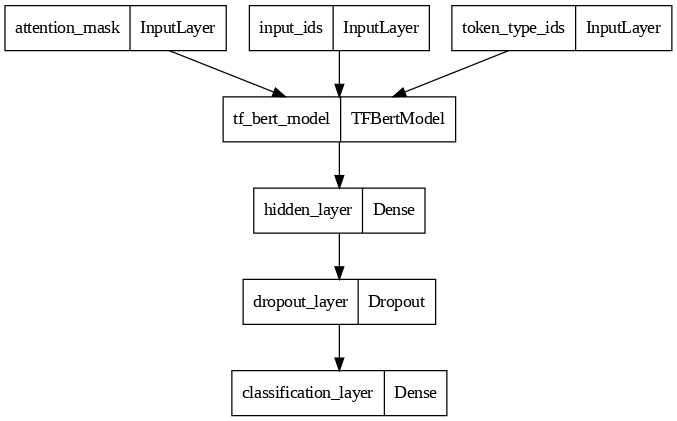

In [8]:
keras.utils.plot_model(bert_multiclass_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [9]:
# Define a callback to save weights after each batch
#class SaveWeightsCallback(tf.keras.callbacks.Callback):
#    def on_batch_end(self, batch, logs=None):
#        model.save_weights(
#            f'/content/drive/My Drive/w266_Project/ProjectStore/model_weights_batch{batch}.h5')
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    def on_batch_end(self, batch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights.h5"
        self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights_epoch{epoch}.h5"
        self.model.save_weights(model_filename)

save_weights_callback = SaveWeightsCallback(model_name='bert_multiclass_model')

# Create Encodings

In [10]:
def create_bert_encoding(data, label):
  data_encodings = bert_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)

  return (data_encodings, label_encodings)

In [11]:
# delete me
# os.getcwd()
# help(os)
# os.chdir('')
os.chdir('/content/drive/MyDrive/w266_Project/ProjectStore/')
os.listdir()

['nltk_corpus_df.csv',
 'Base BERT Models',
 'checkpoint',
 'bert_classification_model_weights_batch95.h5',
 'bert_classification_model_weights_epoch0.h5',
 'bert_classification_model_weights_batch0.h5',
 'predictions_multi.csv',
 'predictions_multi.gsheet',
 'nltk_corpus_df_chunks.parquet',
 'nltk_corpus_train_data_binary.parquet',
 'nltk_corpus_test_data_binary.parquet',
 'nltk_corpus_valid_data_binary.parquet',
 'nltk_corpus_train_data_multi.parquet',
 'nltk_corpus_valid_data_multi.parquet',
 'nltk_corpus_test_data_multi.parquet',
 'nltk_corpus_train_data_multi5.parquet',
 'nltk_corpus_test_data_multi5.parquet',
 'nltk_corpus_valid_data_multi5.parquet',
 'data',
 'training',
 'bert_multiclass_model_weights.h5',
 'bert_multiclass_model_weights_epoch0.h5']

In [12]:

# Create Train and Validation encodings
BATCH_SIZE = 100

# Load Test Data and prepare encodings
is_denny = True

file_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
if is_denny:
  file_path = '/content/drive/MyDrive/w266_Project/ProjectStore/' # Changed to MyDrive

train_file = file_path + "nltk_corpus_train_data_multi.parquet"
valid_file = file_path + "nltk_corpus_valid_data_multi.parquet"
test_file = file_path + "nltk_corpus_test_data_multi.parquet"

# convert to training, validation, and test lists
# parquet -> pandas -> lists
def convert_parquet_to_data_label_lists(file_path)->(list, list):
  data = pya.parquet.read_table(file_path)
  df = data.to_pandas()
  assert 'Data' in str(df.columns[0]), 'Expected first column to contain Data, not label'
  data_list = list(df.iloc[:,0].values)

  assert 'Label' in str(df.columns[1]), 'Expected second column to contain Labels. It doesnt.'
  label_list = list(df.iloc[:,1].values)

  return data_list, label_list

df_train = pya.parquet.read_table(train_file).to_pandas()
train_data = list(df_train['Train Data'].values)
train_label =list(df_train['Train Label'].values)

df_valid = pya.parquet.read_table(valid_file).to_pandas()
valid_data = list(df_valid['Valid Data'].values)
valid_label = list(df_valid['Valid Label'].values)

df_test = pya.parquet.read_table(test_file).to_pandas()
test_data  = list(df_test['Test Data'].values)
test_label = list(df_test['Test Label'].values)

# Create a dataset
train_encodings, train_enc_label = create_bert_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_bert_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_bert_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': train_encodings['input_ids'],
      'token_type_ids': train_encodings['token_type_ids'],
      'attention_mask': train_encodings['attention_mask']},
     train_enc_label))

dataset_training = dataset_training.batch(BATCH_SIZE)  # Batch size

dataset_validation = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': valid_encodings['input_ids'],
      'token_type_ids': valid_encodings['token_type_ids'],
      'attention_mask': valid_encodings['attention_mask']},
     valid_enc_label))

dataset_validation = dataset_validation.batch(BATCH_SIZE)

In [15]:
type(dataset_training)

tensorflow.python.data.ops.batch_op._BatchDataset

# Train Model

In [ ]:
# Train the model with the SaveWeightsCallback
bert_multiclass_model_history = bert_multiclass_model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=[save_weights_callback])


 1/96 [..............................] - ETA: 3:28:39 - loss: 1.9425 - accuracy: 0.3500

In [ ]:
#train_encodings, train_enc_label = create_bert_partial_encoding(train_data[101:200],
#                                                                train_label[101:200])
#valid_encodings, valid_enc_label = create_bert_partial_encoding(valid_data[500:600],
#                                                                valid_label[500:600])

#model.load_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

In [ ]:
#import pickle

# Specify the file path for saving the history object
#history_file_path = '/content/drive/My Drive/w266_Project/ProjectStore/training_history.pkl'

# Save the history object to the specified file path using pickle
#with open(history_file_path, 'wb') as file:
#    pickle.dump(bert_classification_model_history.history, file)

In [ ]:
#train_encodings, train_enc_label = create_bert_partial_encoding(train_data[200:700],
#                                                                  train_label[200:700])
#valid_encodings, valid_enc_label = create_bert_partial_encoding(valid_data[500:600],
#                                                                  valid_label[500:600])

#model = create_bert_classification_model(bert_model, num_train_layers=0)
#model.load_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

#bert_classification_model_history = model.fit(
#    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
#    train_enc_label,
#    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
#    valid_enc_label),
#    batch_size=8,
#    epochs=1)

#model.save_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")

63/63 [==============================] - 1756s 27s/step - loss: 0.6923 - accuracy: 0.6060 - val_loss: 0.6290 - val_accuracy: 0.6700


In [ ]:
#model.save_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")
#filename = "/content/drive/My Drive/w266 Project/ProjectStore/wgt"
#model.save_weights(filename)
#model.load_weights('/content/drive/My Drive/w266 Project/ProjectStore/wgt')

In [ ]:

#bert_classification_model_history = bert_classification_model.fit(
#    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
#    train_enc_label,
#    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
#    valid_enc_label),
#    batch_size=8,
#    epochs=1)

# Evaluate Model

In [ ]:
# Load stored model weights
checkpoint_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
if is_denny:
  checkpoint_path = "/content/drive/MyDrive/w266_Project/ProjectStore/"
bert_multiclass_model.load_weights(checkpoint_path + 'bert_multiclass_model_weights_epoch0.h5')

In [ ]:
score = bert_multiclass_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_enc_label)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

86/86 [==============================] - 3071s 35s/step - loss: 1.5572 - accuracy: 0.4170
Test loss: 1.5572386980056763
Test accuracy: 0.41703057289123535


In [ ]:
predictions = bert_multiclass_model.predict(
    [test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
#predictions

86/86 [==============================] - 2989s 35s/step


In [ ]:
for i in range (len(predictions)):
  print(predictions[i])


Streaming output truncated to the last 5000 lines.
[0.00193686 0.14938608 0.00150024 0.04586371 0.01220755 0.02568503
 0.00733528 0.39550647 0.0010887  0.24993257 0.10955755]
[0.00155362 0.35219124 0.00246304 0.03900855 0.01830304 0.02703362
 0.0044184  0.18258816 0.00171105 0.16227683 0.20845242]
[0.00173376 0.36675307 0.00272422 0.03500117 0.01929462 0.02324002
 0.00361784 0.16687474 0.00167893 0.16904266 0.21003895]
[0.0019644  0.3079973  0.00293698 0.04308474 0.0177516  0.03058407
 0.00578473 0.19178711 0.00219512 0.1937625  0.20215152]
[0.00228399 0.20302328 0.00188542 0.05149895 0.01328478 0.03175091
 0.00760325 0.31732446 0.00199932 0.24072464 0.12862098]
[0.00154602 0.4053375  0.00148089 0.03503373 0.00934905 0.02637538
 0.00371876 0.2305894  0.00155527 0.15582125 0.12919271]
[0.00285369 0.25323576 0.00348353 0.05909169 0.03243726 0.02041724
 0.00510838 0.26883486 0.00188127 0.15805514 0.19460128]
[0.0013833  0.3086985  0.00262576 0.03935969 0.02016796 0.02549312
 0.0043866  0.

In [ ]:
np.savetxt('/content/drive/My Drive/w266_Project/ProjectStore/predictions_multi.csv', predictions)


In [ ]:
test_label[2745]
#len(predictions)

8

In [ ]:
# Save the trained model
# to load the model again: model = load_model('...')
#bert_classification_model.save('/content/drive/My Drive/w266 Project/ProjectStore/bert_binclass_base_model.keras')

In [ ]:
score

[2.2444844245910645, 0.6986899375915527]

In [ ]:
predictions

array([[0.00072889],
       [0.00068637],
       [0.00048361],
       [0.00064717],
       [0.00050687]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

prediction_max = []
for i in range(len(predictions)):
  prediction_max.append(np.argmax(predictions[i]))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_label, prediction_max)

# Calculate accuracy using TensorFlow
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_label, prediction_max)
accuracy_result = accuracy.result().numpy()

# Calculate precision, recall, and F1 score using TensorFlow
precision = tf.keras.metrics.Precision()
precision.update_state(test_label, prediction_max)
precision_result = precision.result().numpy()

recall = tf.keras.metrics.Recall()
recall.update_state(test_label, prediction_max)
recall_result = recall.result().numpy()

f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy_result)
print("\nPrecision:", precision_result)
print("Recall:", recall_result)
print("F1 Score:", f1)

# Classification report using scikit-learn
class_report = classification_report(test_label, prediction_max)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[596   0   0   0 217   8   7]
 [ 40   0   0   0  88   6  10]
 [  8   0   0   0  39   2   5]
 [ 28   0   0   0  54   2   2]
 [190   0   0   0 403  15  11]
 [227   0   0   0 182  83  21]
 [243   0   0   0 158  39  64]]

Accuracy: 0.41703057

Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.72      0.55       828
           3       0.00      0.00      0.00       144
           4       0.00      0.00      0.00        54
           5       0.00      0.00      0.00        86
           7       0.35      0.65      0.46       619
           9       0.54      0.16      0.25       513
          10       0.53      0.13      0.21       504

    accuracy                           0.42      2748
   macro avg       0.27      0.24      0.21      2748
weighted avg       0.41      0.42      0.35      2748



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1

0.9236192426444707

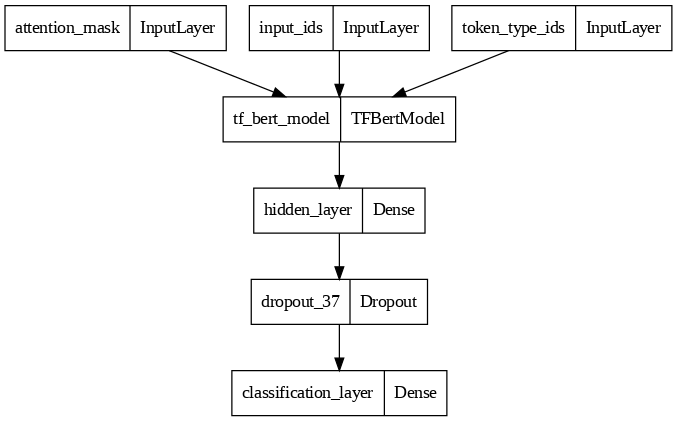

In [ ]:
keras.utils.plot_model(bert_multiclass_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)